# Feature Selection

## Environment setup and functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [85]:
def prepare_data(mode):
    assert(mode in ("train", "valid"))
    X = pd.read_csv(f"data/arcene_{mode}.data", sep=" ", header=None).iloc[:, :-1]
    y = pd.read_csv(f"data/arcene_{mode}.labels", header=None)

    X = X.to_numpy()
    y = y.to_numpy().ravel()

    # convert labels to 0 and 1
    y[y == -1] = 0

    return X, y

In [86]:
def search_knn(X, y, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 15, 21, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2],
    }
    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(knn, param_grid, scoring="balanced_accuracy", cv=skf, verbose=1)
    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

In [87]:
def search_rf(X, y, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    param_grid = {"n_estimators": [100, 200, 300]}
    rf = RandomForestClassifier()

    grid_search = GridSearchCV(rf, param_grid, scoring="balanced_accuracy", cv=skf, verbose=1)
    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

In [88]:
def search_xgboost(X, y, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    param_grid = {"max_depth": [7, 9], "learning_rate": [0.01, 0.005], "n_estimators": [200, 300]}
    xgb = XGBClassifier()

    grid_search = GridSearchCV(xgb, param_grid, scoring="balanced_accuracy", cv=skf, verbose=1)
    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

In [89]:
def evaluate(X, y, X_v, y_v, params_knn=None, params_rf=None, params_xgb=None):
    X_train, X_test = X, X_v
    y_train, y_test = y, y_v

    # KNN Classifier
    knn = KNeighborsClassifier(**params_knn)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_scores = balanced_accuracy_score(y_test, knn_pred)

    # Random Forest Classifier
    rf = RandomForestClassifier(**params_rf)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_scores = balanced_accuracy_score(y_test, rf_pred)

    # XGBoost Classifier
    xgb = XGBClassifier(**params_xgb)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_scores = balanced_accuracy_score(y_test, xgb_pred)

    return {
        "KNN": knn_scores,
        "RF": rf_scores,
        "XGB": xgb_scores,
    }

## Selection

I decided to test three methods of Feature Selection: Lasso, Random Forest and Mutual Information. I ran each method with three different classification algorithms (KNN, Random Forest and XGBoost) with parameters defined by small gridsearch. Metric used to evaluate those methods was Balanced Accuracy Score.

In [90]:
X, y = prepare_data("train")
X_v, y_v = prepare_data("valid")

In [95]:
c_lasso = [(i+2)/10000 for i in range(9)] + [(i+1)/1000 for i in range(100)] + [(i+1)/10 for i in range(10)]

In [96]:
scores_knn = []
scores_rf = []
scoeres_xgb = []
params_knn_a = []
params_rf_a = []
params_xgb_a = []
features = []
n_features = []

### Lasso

In [97]:
for c in c_lasso:
    print(f"_____ C={c} _____")
    lasso = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=5000)
    lasso.fit(X, y)

    sfm = SelectFromModel(lasso, prefit=True)
    X_selected = sfm.transform(X)
    X_v_selected = sfm.transform(X_v)
    selected_feature_indices = sfm.get_support(indices=True)
    num_features = X_selected.shape[1]
    print(f"{num_features} features selected")

    params_knn, score_knn = search_knn(X_selected, y)
    params_rf, score_rf = search_rf(X_selected, y)
    params_xgb, score_xgb = search_xgboost(X_selected, y)

    scores = evaluate(X_selected, y, X_v_selected, y_v, params_knn=params_knn, params_rf=params_rf, params_xgb=params_xgb)

    scores_knn.append(scores['KNN'])
    scores_rf.append(scores['RF'])
    scoeres_xgb.append(scores['XGB'])
    params_knn_a.append(params_knn)
    params_rf_a.append(params_rf)
    params_xgb_a.append(params_xgb)
    n_features.append(num_features)
    features.append(selected_feature_indices)

    print(f"KNN {scores['KNN']} | RF {scores['RF']} | XGB {scores['XGB']}")

_____ C=0.0002 _____
2 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.6363636363636364 | RF 0.6493506493506493 | XGB 0.6525974025974026
_____ C=0.0003 _____
3 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.612012987012987 | RF 0.5925324675324675 | XGB 0.6217532467532467
_____ C=0.0004 _____
4 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.7426948051948052 | RF 0.7670454545454546 | XGB 0.6452922077922079
_____ C=0.0005 _____
4 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 fol

In [98]:

algorithm = ["lasso" for i in range(len(n_features))]

### Random Forest

In [99]:
rf_features = [i for i in range(4, 500, 5)]

In [101]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)

RandomForestClassifier()

In [103]:
for features_ in rf_features:
    print(f"_____ features={features_} _____")

    sfm = SelectFromModel(rf_clf, prefit=True, max_features=features_)
    X_selected = sfm.transform(X)
    X_v_selected = sfm.transform(X_v)
    selected_feature_indices = sfm.get_support(indices=True)
    num_features = X_selected.shape[1]
    print(f"{num_features} features selected")

    params_knn, score_knn = search_knn(X_selected, y)
    params_rf, score_rf = search_rf(X_selected, y)
    params_xgb, score_xgb = search_xgboost(X_selected, y)

    scores = evaluate(X_selected, y, X_v_selected, y_v, params_knn=params_knn, params_rf=params_rf, params_xgb=params_xgb)

    scores_knn.append(scores['KNN'])
    scores_rf.append(scores['RF'])
    scoeres_xgb.append(scores['XGB'])
    params_knn_a.append(params_knn)
    params_rf_a.append(params_rf)
    params_xgb_a.append(params_xgb)
    n_features.append(num_features)
    features.append(selected_feature_indices)
    algorithm.append("rf")

    print(f"KNN {scores['KNN']} | RF {scores['RF']} | XGB {scores['XGB']}")

_____ features=4 _____
4 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.7475649350649352 | RF 0.700487012987013 | XGB 0.698051948051948
_____ features=9 _____
9 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.6939935064935066 | RF 0.6323051948051948 | XGB 0.575487012987013
_____ features=14 _____
14 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.7272727272727273 | RF 0.6728896103896104 | XGB 0.6209415584415584
_____ features=19 _____
19 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fit

### Mutual Information

In [107]:
mi_features = [i for i in range(4, 40, 3)] + [i for i in range(40, 100, 5)] + [i for i in range(100, 510, 10)]

In [108]:
selector = SelectKBest(score_func=mutual_info_classif, k="all")
selector.fit(X, y)
scores = selector.scores_
feature_indices = np.argsort(scores)[::-1]

In [112]:
for features_ in mi_features:
    print(f"_____ features={features_} _____")

    selected_feature_indices = feature_indices[:features_]
    X_selected = X[:, selected_feature_indices]
    X_v_selected = X_v[:, selected_feature_indices]

    num_features = X_selected.shape[1]
    print(f"{num_features} features selected")

    params_knn, score_knn = search_knn(X_selected, y)
    params_rf, score_rf = search_rf(X_selected, y)
    params_xgb, score_xgb = search_xgboost(X_selected, y)

    scores = evaluate(X_selected, y, X_v_selected, y_v, params_knn=params_knn, params_rf=params_rf, params_xgb=params_xgb)

    scores_knn.append(scores['KNN'])
    scores_rf.append(scores['RF'])
    scoeres_xgb.append(scores['XGB'])
    params_knn_a.append(params_knn)
    params_rf_a.append(params_rf)
    params_xgb_a.append(params_xgb)
    n_features.append(num_features)
    features.append(selected_feature_indices)
    algorithm.append("mi")

    print(f"KNN {scores['KNN']} | RF {scores['RF']} | XGB {scores['XGB']}")

_____ features=4 _____
4 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.5917207792207793 | RF 0.6501623376623377 | XGB 0.5397727272727273
_____ features=7 _____
7 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.7491883116883117 | RF 0.6363636363636364 | XGB 0.625
_____ features=10 _____
10 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN 0.7378246753246753 | RF 0.6631493506493507 | XGB 0.6136363636363636
_____ features=13 _____
13 features selected
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 fol

## Analysis

In [114]:
df = pd.DataFrame(data=np.array([algorithm, n_features, scores_knn, scores_rf, scoeres_xgb]).transpose(), columns=["algorithm", "features", "knn", "rf", "xgb"])

In [121]:
df1 = df.drop_duplicates(
  subset = ["algorithm", "features"],
  keep = 'first').reset_index(drop = True)

In [129]:
df1["features"] = df1["features"].astype("int64")
df1["knn"] = df1["knn"].astype("float64")
df1["rf"] = df1["rf"].astype("float64")
df1["xgb"] = df1["xgb"].astype("float64")

In [133]:
df1.dtypes

algorithm     object
features       int64
knn          float64
rf           float64
xgb          float64
dtype: object

In [134]:
df1.to_csv("results.csv")

In [2]:
df1 = pd.read_csv("results.csv")

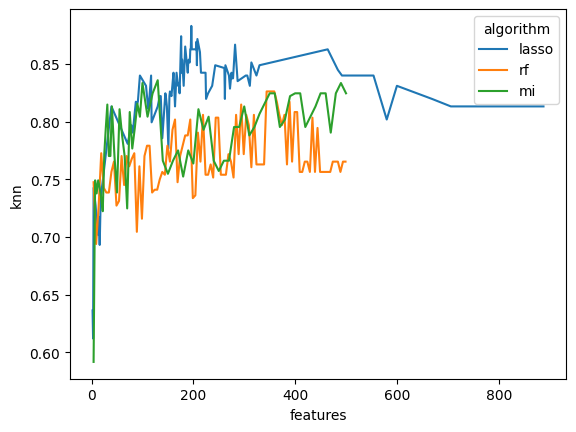

In [3]:
sns.lineplot(data=df1, x="features", y="knn", hue="algorithm")
plt.show()

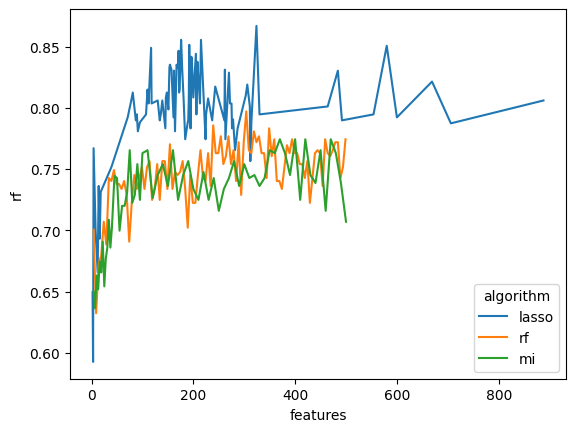

In [143]:
sns.lineplot(data=df1, x="features", y="rf", hue="algorithm")
plt.show()

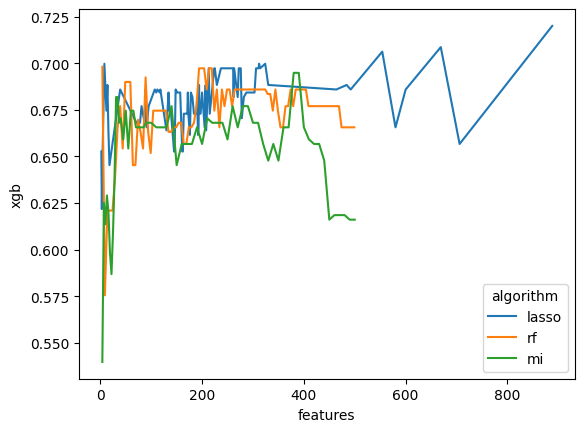

In [144]:
sns.lineplot(data=df1, x="features", y="xgb", hue="algorithm")
plt.show()

Results shows taht in this particular case Lasso with KNN had the best performance. We can see that Lasso was better than Random Forest and Mutual Information across all used classification algorithms. 